In [5]:
import pickle

def get_dist_matrix(pklname='/projects/0/einf2380/data/pop_paper_data/allele_clustering/HLA_all.pkl'):
    with open(pklname, 'rb') as inpkl:
        name = pickle.load(inpkl)
        seq = pickle.load(inpkl)
        score = pickle.load(inpkl)
        dist = pickle.load(inpkl)
        linkage = pickle.load(inpkl)
        dendrogram = pickle.load(inpkl)

    matrix = {}
    for i, x in enumerate(name):
        matrix[x] = { y:dist[i+j]  for j, y in enumerate(name[i+1:])}
    
    return {'matrix': matrix, 'linkage': linkage, 'distances' : dist, 
            'name':name, 'seq':seq, 'score':score, 'dendrogram' : dendrogram}

matrix = {}
matrix['A'] = get_dist_matrix(pklname='/projects/0/einf2380/data/pop_paper_data/allele_clustering/HLAA.pkl')
matrix['B'] = get_dist_matrix(pklname='/projects/0/einf2380/data/pop_paper_data/allele_clustering/HLAB.pkl')
matrix['C'] = get_dist_matrix(pklname='/projects/0/einf2380/data/pop_paper_data/allele_clustering/HLAC.pkl')
matrix['ALL'] = get_dist_matrix(pklname='/projects/0/einf2380/data/pop_paper_data/allele_clustering/HLA_all.pkl')

In [6]:
import radialtree as rt
#from omniplot.utils import _radialtree as rt
import pandas as pd

import matplotlib.font_manager
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 1, figsize=(10, 10))
with plt.rc_context({'lines.linewidth': 10}):
    rt.radialTreee(matrix["A"]["dendrogram"])

fig, axes = plt.subplots(1, 1, figsize=(10, 10))
with plt.rc_context({'lines.linewidth': 10}):
    rt.radialTreee(matrix["B"]["dendrogram"])

fig, axes = plt.subplots(1, 1, figsize=(10, 10))
with plt.rc_context({'lines.linewidth': 10}):
    rt.radialTreee(matrix["C"]["dendrogram"])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


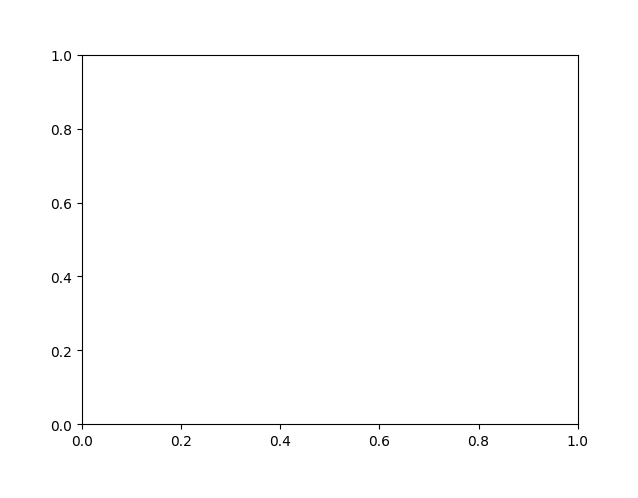

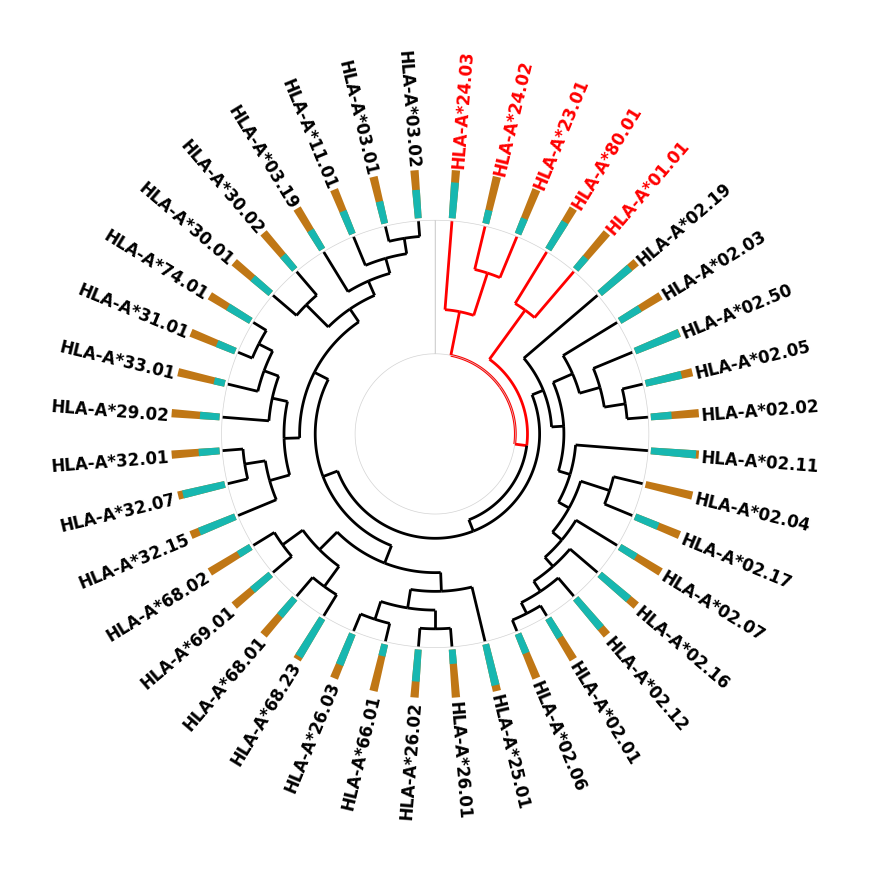

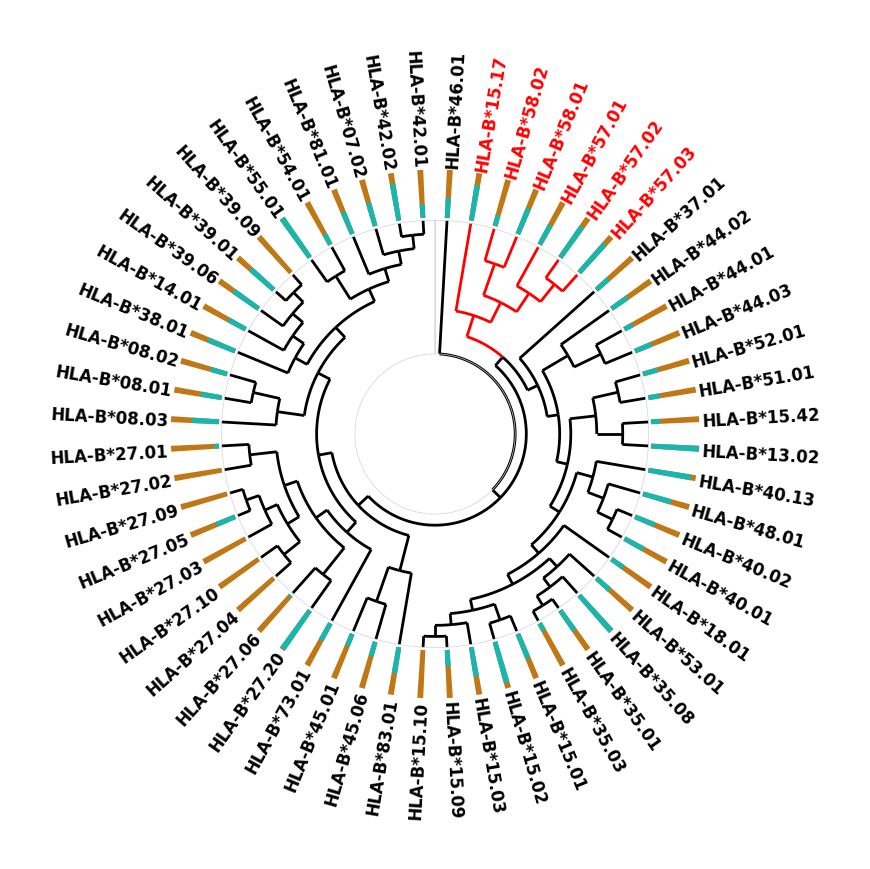

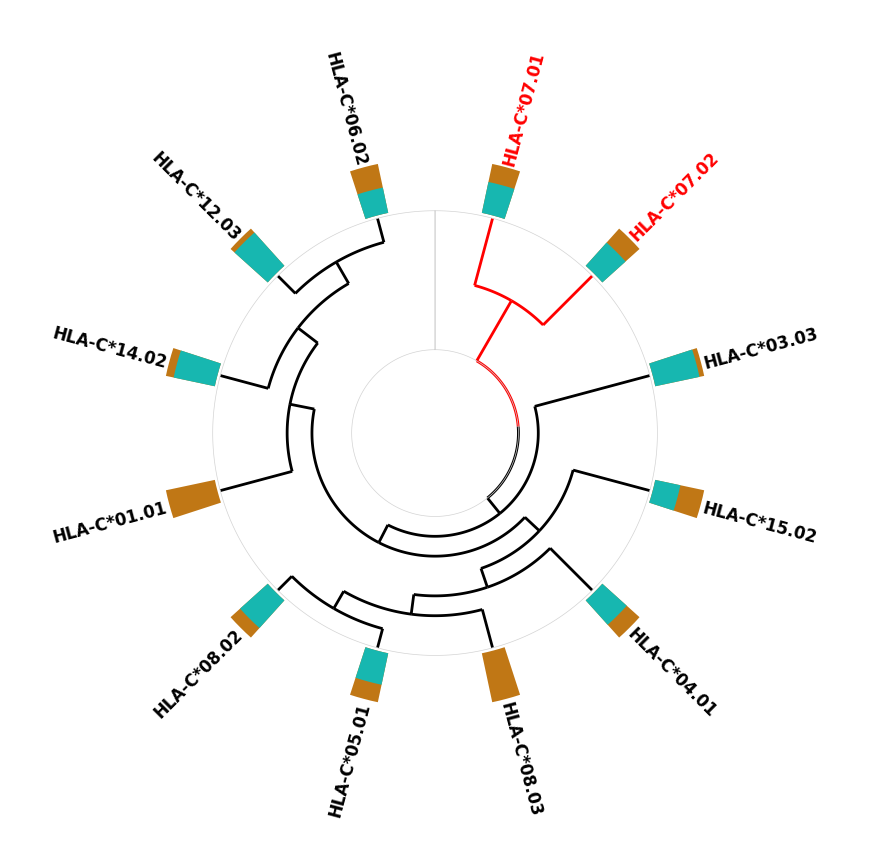

In [ ]:
from pycirclize import Circos
import numpy as np
import pandas as pd
from io import StringIO
from Bio import Phylo

def get_tree_string(linkage, dendrogram, names):

    tree_string = ''
    max_leaf = len(dendrogram['ivl'])
    nodes = []
    for i, x in enumerate(linkage):
        left_idx = int(x[0])
        right_idx = int(x[1])
        distance = x[2]
        #print(x, left_idx, right_idx)
        if x[3] == 2.: #primary node
            leaf_1 = names[left_idx]
            leaf_2 = names[right_idx]
            new_node = f'({leaf_1}:{distance},{leaf_2}:{distance})'
            #print(f'NEW_node: {new_node}')
            nodes.append(new_node)
            #print(nodes)
        else:
            if left_idx >= max_leaf:
                #print('WARN')
                new_idx = left_idx - max_leaf
                leaf_1 = nodes[new_idx]
                left_side = f'({leaf_1}:{distance}'
            else:
                leaf_1 = names[left_idx]
                left_side = f'{leaf_1}:{distance}'
            if right_idx >= max_leaf:
                #print('WARN')
                new_idx = right_idx - max_leaf
                #print(x)
                #print(nodes, new_idx)
                leaf_2 = nodes[new_idx]
                right_side = f'{leaf_2}:{distance})'
            else:
                leaf_2 = names[right_idx]
                right_side = f'{leaf_2}:{distance}'
        
            new_node = f'({leaf_1}:{distance},{leaf_2}:{distance})'
            #print(f'NEW_composite_node: {new_node}')
            nodes.append(new_node)
        #print(leaf_1, leaf_2)
    return nodes

def plot_flat_and_round_dendrogram(treedata, df, dendrogram_leaves, test_nodes, train_nodes, save = False):
    tree = Phylo.read(StringIO(treedata), "newick")
    # Plot normal dendrogram
    # Phylo.draw(tree)



    # Initialize circos sector with tree size
    circos = Circos(sectors={"Tree": tree.count_terminals()})
    sector = circos.sectors[0]

    # Plot tree
    track = sector.add_track((30, 80)) 
    track.tree(tree, 
            leaf_label_size=12, 
            leaf_label_margin=20.,
            node_color_list=[
                (test_nodes, "red"),
                (train_nodes, "black")],
                # (["G", "M"], "blue"),
                # (["A", "H"], "green"),
                # (["R", "P"], "purple"),
                # (["J"], "orange"),]
            line_kws=dict(lw=2),
            text_kws=dict(fontweight='bold')
            #label_formatter=lambda t.label: t.label.replace(".", ":"),
        )
    track.axis(ec="lightgrey")
    #bottom bar for the total of cases
    bottom_bar_track = sector.add_track((80, 100), r_pad_ratio=0.1)
    x = np.arange(0, int(sector.size)) + 0.5
    height = np.asarray([10 for x in range(int(sector.size))])
    bottom_bar_track.bar(x, height, width = 0.2, color="#c07715", lw=0.5, vmin=0, vmax=10)
    #top bar for % of positives
    top_bar_track = sector.add_track((80, 100), r_pad_ratio=0.1)
    x = np.arange(0, int(sector.size)) + 0.5
    height = np.asarray([calculate_percentage(df, allele)/10 for allele in dendrogram_leaves])
    top_bar_track.bar(x, height, width = 0.2, color="#17b7b0", lw=0.5, vmin=0, vmax=10)

    #with plt.rc_context({'lines.linewidth': 10}):
    fig = circos.plotfig()
    if save:
        plt.savefig(f'{save}.pdf')
        plt.savefig(f'{save}.png', dpi=800)

def calculate_percentage(df, allele):
    # Filter rows based on specific value in 'allele' column
    filtered_df = df[df['allele'] == allele]
    
    # Count datapoints with measurement_value < 500
    count_below_500 = len(filtered_df[filtered_df['measurement_value'] <= 500.])
    
    # Calculate percentage
    total_datapoints = len(filtered_df)
    if total_datapoints == 0:
        return 0  # Handle the case where there are no datapoints for the specific allele
    percentage_below_500 = (count_below_500 / total_datapoints) * 100
    
    return percentage_below_500

df = pd.read_csv('/projects/0/einf2380/data/external/processed/I/BA_pMHCI_human_quantitative_only_eq.csv')

genes = {'A': ['HLA-A*23.01','HLA-A*24.02', 'HLA-A*24.03','HLA-A*01.01','HLA-A*80.01'], #'HLA-A*24.01',
         'B': ['HLA-B*15.17', 'HLA-B*57.01', 'HLA-B*57.02', 'HLA-B*57.03', 'HLA-B*58.01', 'HLA-B*58.02'], 
         'C': ["HLA-C*07.01", "HLA-C*07.02"]}
for gene in genes.keys():
    linkage = matrix[gene]["linkage"]
    dendrogram = matrix[gene]["dendrogram"]
    names = [x.replace(':','.') for x in matrix[gene]["name"]]
    train_nodes = [x for x in names if x not in genes[gene]]
    treedata = get_tree_string(linkage, dendrogram, names)[-1]
    dendrogram_leaves = dendrogram['ivl']
    plot_flat_and_round_dendrogram(treedata, df, dendrogram_leaves, test_nodes = genes[gene], train_nodes=train_nodes, save=f'/home/dmarz/3D-Vac/reports/figures/{gene}_circ_dendrogram')


In [ ]:
''' Test phylo circular plot
import pylab
import networkx as nx

tree = Phylo.read(StringIO(treedata), "newick")
net = Phylo.to_networkx(tree)

nx.draw(net)
pylab.show()

pos = nx.nx_agraph.graphviz_layout(net, prog="twopi", args="")
plt.figure(figsize=(8, 8))
nx.draw(net, pos, node_size=2, alpha=0.5, node_color="blue", with_labels=False)
plt.axis("equal")
plt.show()
'''

' Test phylo circular plot\nimport pylab\nimport networkx as nx\n\ntree = Phylo.read(StringIO(treedata), "newick")\nnet = Phylo.to_networkx(tree)\n\nnx.draw(net)\npylab.show()\n\npos = nx.nx_agraph.graphviz_layout(net, prog="twopi", args="")\nplt.figure(figsize=(8, 8))\nnx.draw(net, pos, node_size=2, alpha=0.5, node_color="blue", with_labels=False)\nplt.axis("equal")\nplt.show()\n'